### Youtube blog Generator

In [1]:
import os
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool


In [2]:
from youtube_transcript_api import YouTubeTranscriptApi
from langgraph.types import Command, interrupt


In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
os.environ["LANGSMITH_PROJECT"] = "Test-Project"
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"

In [5]:
llm = ChatGroq(model_name = "llama-3.3-70b-versatile")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001ECF286B800>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001ECF29CAE70>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    transcript: str
    enriched: str
    draft: str
    suggested_title: str

In [8]:
@tool
def get_youtube_transcript(video_url: str) -> str:
    """Fetch full transcript text from a YouTube video URL."""
    video_id = video_url.split("v=")[-1]
    data = YouTubeTranscriptApi.get_transcript(video_id)
    return " ".join([seg["text"] for seg in data])

# 2. Web search tool using Tavily (up-to-date search integration)
tavily_search = TavilySearch(max_results=3,)

# Optionally, wrap as @tool if you want custom naming or docstring
@tool
def web_search(query: str) -> str:
    """Perform a web search for the given query and return summarized results."""
    res = tavily_search.invoke({"query": query})
    # Extract snippet or answer
    return res.get("answer") or "\n".join([r["content"] for r in res.get("results", [])])

# 3. Human-in-the-loop review tool
@tool
def human_assistance(draft: str, suggested_title: str) -> str:
    """Request assistance from a human."""
    prompt = {
        "query": f"Title: {suggested_title}\n\nDraft:\n{draft}\n\nProvide feedback:"
    }
    feedback = interrupt(prompt)
    return feedback["data"]

In [9]:
tools = [get_youtube_transcript, web_search, human_assistance]

llm_with_tools = llm.bind_tools(tools)

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def agent_node(state: State):
    # Reasoning step: instruct LLM to plan next action
    messages = state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

# Define the state graph
graph_builder = StateGraph(State)

## add nodes
graph_builder.add_node("agent", agent_node)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Add edges

graph_builder.add_edge(START, "agent")

graph_builder.add_conditional_edges(     ## Ensuring the ReACT architecture of agents
    "agent",
    tools_condition,
)
graph_builder.add_edge("tools", "agent")


# In last, compile the grpah
graph = graph_builder.compile(checkpointer=memory)

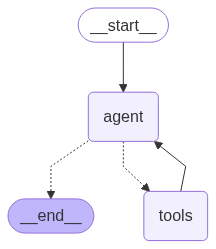

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
user_input = "Hi, Can you tell me to which tools you have acces to?"
config = {"configurable": {"thread_id": "2"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, Can you tell me to which tools you have acces to?
================================== Ai Message ==================================

I have access to the following tools:

1. get_youtube_transcript: Fetch full transcript text from a YouTube video URL.
2. web_search: Perform a web search for the given query and return summarized results.
3. human_assistance: Request assistance from a human.

These tools can be used to provide information, answer questions, and assist with tasks.


In [15]:
# url : https://www.youtube.com/watch?v=LPZh9BOjkQs
user_input = "Please generate an interesting blog post for the following video: https://www.youtube.com/watch?v=LPZh9BOjkQs"

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Please generate an interesting blog post for the following video: https://www.youtube.com/watch?v=LPZh9BOjkQs


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=get_youtube_transcript{"video_url": "https://www.youtube.com/watch?v=LPZh9BOjkQs"}</function>\n<function=human_assistance{"draft": "transcript of the video https://www.youtube.com/watch?v=LPZh9BOjkQs", "suggested_title": "Interesting Blog Post"}</function>'}}

In [17]:
human_response = (
    "We, the experts are here to help! The title which you suggested is absolutely perfect. Now generate the final draft of the blog post abd complete the work."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

<function=human_assistance{"draft": "blog post about https://www.youtube.com/watch?v=LPZh9BOjkQs", "suggested_title": "Uncovering the Secrets of [Video Title]"}</function>


In [18]:
user_input = "So, now that you have the title, generate the blog post which I requested."

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

So, now that you have the title, generate the blog post which I requested.
================================== Ai Message ==================================

<function=human_assistance{"draft": "generate a blog post based on the transcript of https://www.youtube.com/watch?v=LPZh9BOjkQs", "suggested_title": "Uncovering the Secrets of [Video Title]"}</function>


In [19]:
human_command = Command(resume={"data": "approve final draft and publish"})
events = graph.stream(human_command, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

<function=human_assistance{"draft": "generate a blog post based on the transcript of https://www.youtube.com/watch?v=LPZh9BOjkQs", "suggested_title": "Uncovering the Secrets of [Video Title]"}</function>
